In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from time import time
import arviz

#Import the helper functions and all the samplers
from BasicFunctions import *
from TabuSampler import tabu_sampler
from ZanellaSampler import zanella_sampler
from RandomWalkSampler import rw_sampler
from PointwiseSampler import pointwise_sampler 

#Autocorrelation function as implemented by Power and Goldman
@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]
    return np.array(corr)

In [2]:
#Defining the Barker balancing functions
g = lambda t: t/(1+t)

In [3]:
#Generating the database
from DatabaseClass import create_databases

#Global parameters used
lmbd = 50
l = 15 #The number of categories for each record
p_cat = np.array([0.05, 0.15, 0.4, 0.2, 0.2]) #The pval vector for each category
beta = 0.30

p_match, x, y, M_truth, M_reverse_truth = create_databases(lmbd, l, p_cat, beta)

#Other parameters that are needed
N_1 = len(x)
N_2 = len(y)
num_gens = N_1*N_2

print("The golden truth p_match: ", p_match)
print("The number of generators: ", num_gens)
print("The first record of the x database:")
print(x[0, :])
print("The first record of the y database:")
print(y[0,:])
print("The golden truth M vector: ")
print(M_truth)

The golden truth p_match:  0.49975521922742494
The number of generators:  750
The first record of the x database:
[4. 1. 1. 2. 2. 2. 0. 2. 1. 1. 2. 2. 4. 3. 2.]
The first record of the y database:
[1. 2. 4. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 1. 2.]
The golden truth M vector: 
[ 7.  0. 21.  5.  0.  0. 23.  3. 16.  0. 29. 10. 24.  0.  2. 18. 15.  4.
  9.  0.  0. 22.  0. 20. 12.]


In [4]:
#Generate a random M and M_initial to start with
M_initial, M_reverse_initial = random_state(N_1, N_2)

print("The starting state for the simulations:")
print(M_initial)

The starting state for the simulations:
[18.  0.  0.  0.  0. 25.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 30. 14.  0.  2.  0.  0.]


In [5]:
#Running the random walk sampler
N = int(1e4)
trace_rw, energy_rw, hamming_rw, num_iter_rw, runtime_rw = rw_sampler(N, N_1, N_2, lmbd, p_match, M_truth,
                                                                    M_initial, M_reverse_initial, p_cat, l, beta, x,
                                                                    y, print_rate=10)

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.034
Runtime:  20.03


In [6]:
#Running the pointwise sampler
trace_pw, energy_pw, hamming_pw, num_iter_pw, runtime_pw = pointwise_sampler(N, N_1, N_2, lmbd, p_match, g, M_truth, M_initial,
                                                                              M_reverse_initial, p_cat, l, beta, x, y, print_rate=10)

Percent: [--------------------------------------->] 100%
Acceptance ratio:  0.645
Runtime:  186.66


In [7]:
#Running the Zanella sampler
T = 150
thin_rate = 0.015
print_rate = 10
N = int(T/thin_rate)
trace_z, energy_z, hamming_z, num_iter_z, runtime_z = zanella_sampler(N_1, N_2,
                                                                                num_gens,
                                                                                M_initial, M_reverse_initial,
                                                                                g, T, M_truth,
                                                                                thin_rate, print_rate, lmbd, p_match,
                                                                                l, p_cat, beta, x, y)

Percent: [--------------------------------------->] 100%Runtime:  126.59


In [8]:
#Running the Tabu sampler
T = 300
thin_rate = 0.03

trace_t, energy_T, hamming_t, alpha, num_iter_t, runtime_t = tabu_sampler(N_1, N_2,
                                                                                num_gens,
                                                                                M_initial, M_reverse_initial,
                                                                                g, T, M_truth,
                                                                                thin_rate, print_rate, lmbd, p_match,
                                                                                l, p_cat, beta, x, y)

Percent: [--------------------------------------->] 100%Average excursion length:  9.0
Runtime:  123.17


In [9]:
## The number of matched identities trace

#The placeholders
num_matched_rw = np.zeros(N)
num_matched_pw = np.zeros(N)
num_matched_t = np.zeros(N)
num_matched_z = np.zeros(N)

#For the random walk sampler
for i in np.arange(0,N):
    x = trace_rw[i,:]
    num_matched_rw[i] = len(x[x != 0])

#For the pointwise sampler
for i in np.arange(0,N):
    x = trace_pw[i,:]
    num_matched_pw[i] = len(x[x != 0])
    
#For the Zanella sampler
for i in np.arange(0,N):
    x = trace_z[i,:]
    num_matched_z[i] = len(x[x != 0])

#For the tabu sampler
for i in np.arange(0,N):
    x = trace_t[i,:]
    num_matched_t[i] = len(x[x != 0])


In [10]:
#Calculating the effective sample sizes
ESS_num_rw = arviz.ess(num_matched_rw)/runtime_rw
ESS_num_pw = arviz.ess(num_matched_pw)/runtime_pw
ESS_num_z = arviz.ess(num_matched_t)/runtime_z
ESS_num_t = arviz.ess(num_matched_z)/runtime_t

ESS_energy_rw = arviz.ess(energy_rw)/runtime_rw
ESS_energy_pw = arviz.ess(energy_pw)/runtime_pw
ESS_energy_t = arviz.ess(energy_z)/runtime_t
ESS_energy_z = arviz.ess(energy_T)/runtime_z

ESS_hamming_rw = arviz.ess(hamming_rw)/runtime_rw
ESS_hamming_pw = arviz.ess(hamming_pw)/runtime_pw
ESS_hamming_t = arviz.ess(hamming_z)/runtime_t
ESS_hamming_z = arviz.ess(hamming_t)/runtime_z

#The acceptance ratios
acc_ratio_rw = 0.0326
acc_ratio_pw = 0.6619

#Mean reversion for the Tabu sampler
mean_reversion = 11

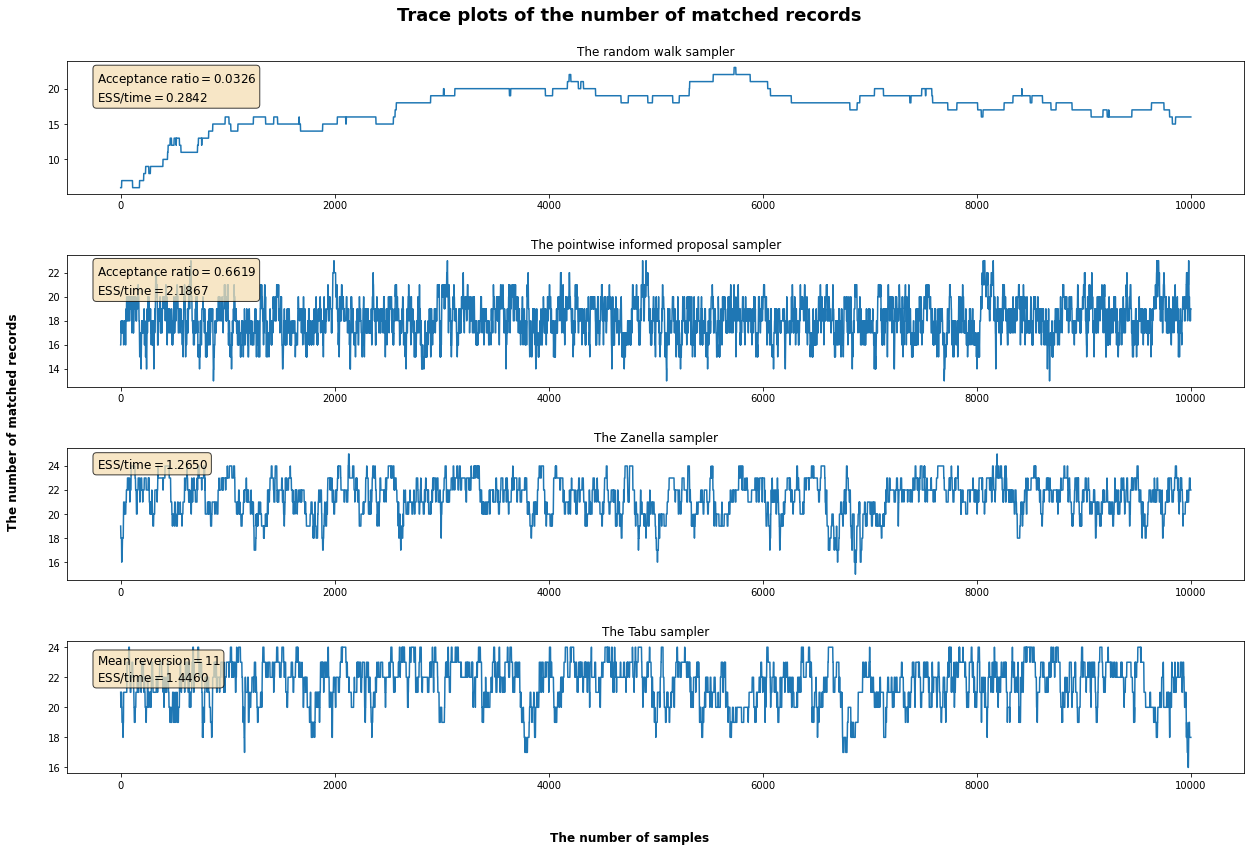

In [11]:
#Trace plot for the number of matched records
fig, ax = plt.subplots(4, 1, figsize=(18,12))
fig.suptitle("Trace plots of the number of matched records", fontsize=18, fontweight="bold")
fig.supylabel("The number of matched records", fontweight="bold")
fig.supxlabel("The number of samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

#The random walk subplot
ax[0].plot(num_matched_rw)
ax[0].set_title("The random walk sampler")

#Adding a textbox
str_rw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_rw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_num_rw, )))

ax[0].text(0.025, 0.7, str_rw,  fontsize=12, bbox=props, transform=ax[0].transAxes)

#The pointwise subplot
ax[1].plot(num_matched_pw)
ax[1].set_title("The pointwise informed proposal sampler")

#Adding a textbox
str_pw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_pw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_num_pw, )))

ax[1].text(0.025, 0.7, str_pw,  fontsize=12, bbox=props, transform=ax[1].transAxes)

#The Zanella sampler
ax[2].plot(num_matched_z)
ax[2].set_title("The Zanella sampler")

#Adding a textbox
str_z = r'$\mathrm{ESS/time}=%.4f$' % (ESS_num_z, )


ax[2].text(0.025, 0.85, str_z,  fontsize=12, bbox=props, transform=ax[2].transAxes)

ax[3].plot(num_matched_t)
ax[3].set_title("The Tabu sampler")

#Adding a textbox
str_t = '\n'.join((
    r'$\mathrm{Mean \ reversion}=%.0f$' % (mean_reversion, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_num_t, )))

ax[3].text(0.025, 0.7, str_t,  fontsize=12, bbox=props, transform=ax[3].transAxes)
plt.show()

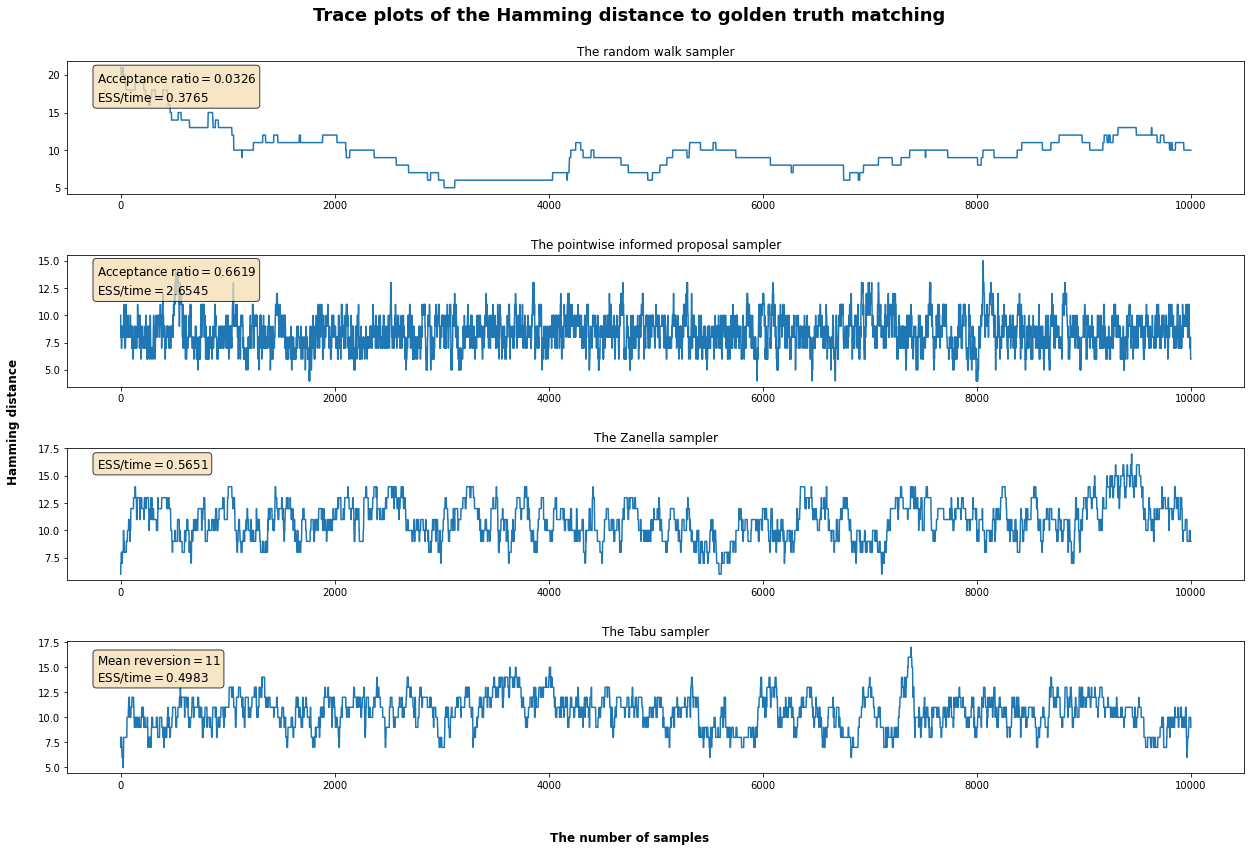

In [12]:
#Trace plot for the hamming distance to the golden truth matching
fig, ax = plt.subplots(4, 1, figsize=(18,12))
fig.suptitle("Trace plots of the Hamming distance to golden truth matching", fontsize=18, fontweight="bold")
fig.supylabel("Hamming distance", fontweight="bold")
fig.supxlabel("The number of samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

#The random walk subplot
ax[0].plot(hamming_rw)
ax[0].set_title("The random walk sampler")

#Adding a textbox
str_rw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_rw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_rw, )))

ax[0].text(0.025, 0.7, str_rw,  fontsize=12, bbox=props, transform=ax[0].transAxes)

#The pointwise subplot
ax[1].plot(hamming_pw)
ax[1].set_title("The pointwise informed proposal sampler")

#Adding a textbox
str_pw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_pw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_pw, )))

ax[1].text(0.025, 0.7, str_pw,  fontsize=12, bbox=props, transform=ax[1].transAxes)

#The Zanella sampler
ax[2].plot(hamming_z)
ax[2].set_title("The Zanella sampler")

#Adding a textbox
str_z = r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_z, )


ax[2].text(0.025, 0.85, str_z,  fontsize=12, bbox=props, transform=ax[2].transAxes)

ax[3].plot(hamming_t)
ax[3].set_title("The Tabu sampler")

#Adding a textbox
str_t = '\n'.join((
    r'$\mathrm{Mean \ reversion}=%.0f$' % (mean_reversion, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_hamming_t, )))

ax[3].text(0.025, 0.7, str_t,  fontsize=12, bbox=props, transform=ax[3].transAxes)
plt.show()

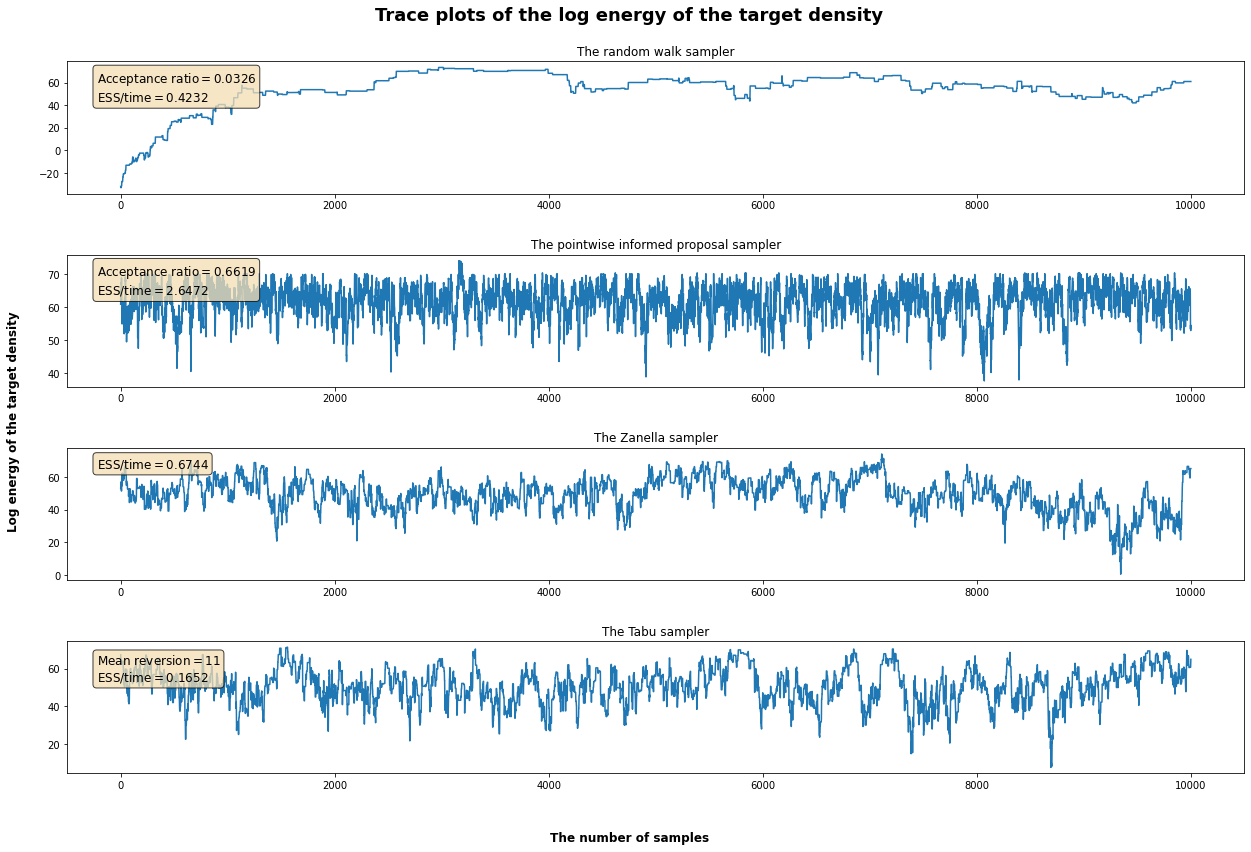

In [13]:
#Trace plot for the log energy of the target density
fig, ax = plt.subplots(4, 1, figsize=(18,12))
fig.suptitle("Trace plots of the log energy of the target density", fontsize=18, fontweight="bold")
fig.supylabel("Log energy of the target density", fontweight="bold")
fig.supxlabel("The number of samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

#The random walk subplot
ax[0].plot(energy_rw)
ax[0].set_title("The random walk sampler")

#Adding a textbox
str_rw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_rw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_rw, )))

ax[0].text(0.025, 0.7, str_rw,  fontsize=12, bbox=props, transform=ax[0].transAxes)

#The pointwise subplot
ax[1].plot(energy_pw)
ax[1].set_title("The pointwise informed proposal sampler")

#Adding a textbox
str_pw = '\n'.join((
    r'$\mathrm{Acceptance \ ratio}=%.4f$' % (acc_ratio_pw, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_pw, )))

ax[1].text(0.025, 0.7, str_pw,  fontsize=12, bbox=props, transform=ax[1].transAxes)

#The Zanella sampler
ax[2].plot(energy_z)
ax[2].set_title("The Zanella sampler")

#Adding a textbox
str_z = r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_z, )


ax[2].text(0.025, 0.85, str_z,  fontsize=12, bbox=props, transform=ax[2].transAxes)

ax[3].plot(energy_T)
ax[3].set_title("The Tabu sampler")

#Adding a textbox
str_t = '\n'.join((
    r'$\mathrm{Mean \ reversion}=%.0f$' % (mean_reversion, ),
    r'$\mathrm{ESS/time}=%.4f$' % (ESS_energy_t, )))

ax[3].text(0.025, 0.7, str_t,  fontsize=12, bbox=props, transform=ax[3].transAxes)
plt.show()

In [14]:
## The autocorrelation arrays for all the considered summary statistics

#The number of matched samples
acorr_num_rw = autocorr(num_matched_rw[int(0.2*N):], np.arange(0, 3000))
acorr_num_pw = autocorr(num_matched_pw[int(0.2*N):], np.arange(0, 3000))
acorr_num_z = autocorr(num_matched_z[int(0.2*N):], np.arange(0, 3000))
acorr_num_t = autocorr(num_matched_t[int(0.2*N):], np.arange(0, 3000))

#Hamming distance to the ground-truth matching
acorr_hamming_rw = autocorr(hamming_rw[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_pw = autocorr(hamming_pw[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_z = autocorr(hamming_z[int(0.2*N):], np.arange(0, 3000))
acorr_hamming_t = autocorr(hamming_t[int(0.2*N):], np.arange(0, 3000))

#Log energy of the target density
acorr_energy_rw = autocorr(energy_rw[int(0.2*N):], np.arange(0, 3000))
acorr_energy_pw = autocorr(energy_pw[int(0.2*N):], np.arange(0, 3000))
acorr_energy_z = autocorr(energy_z[int(0.2*N):], np.arange(0, 3000))
acorr_energy_t = autocorr(energy_T[int(0.2*N):], np.arange(0, 3000))

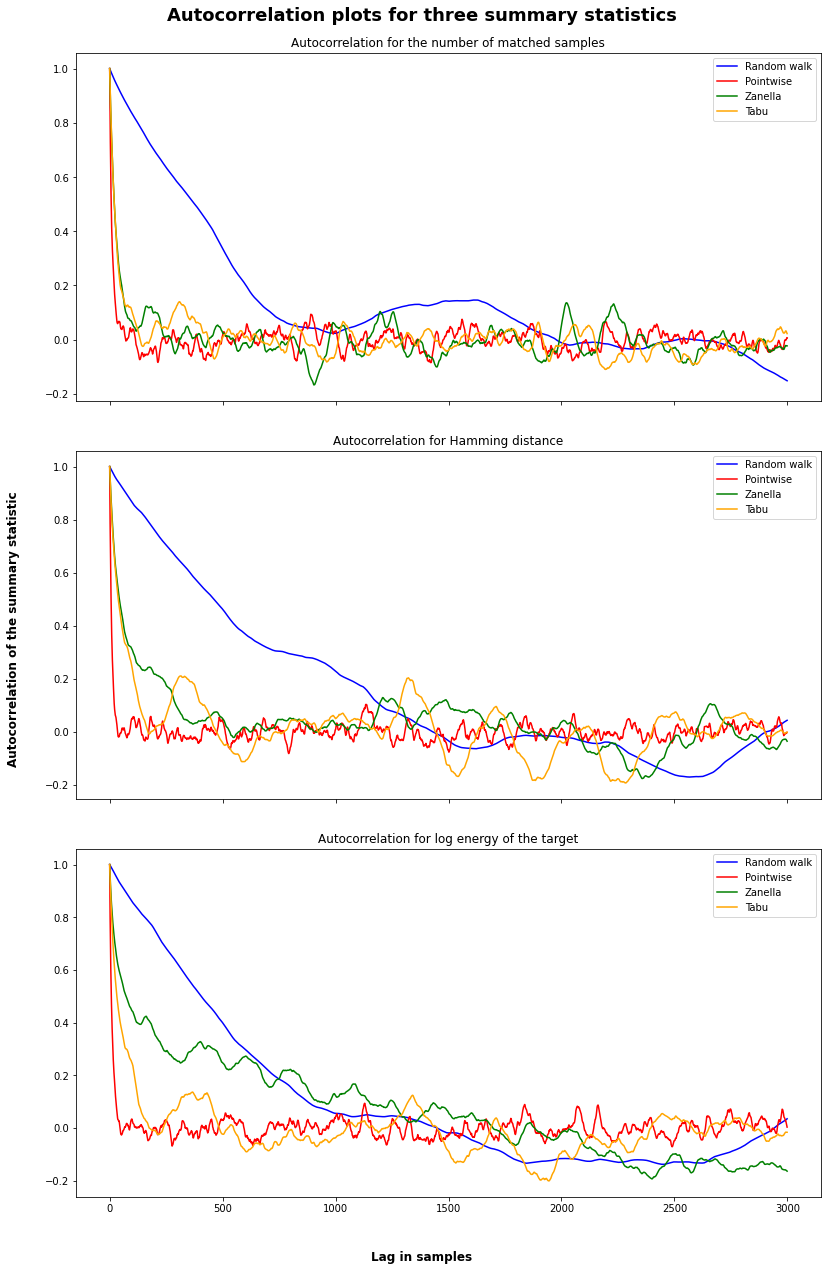

In [15]:
#The actual autocorrelation plot
fig, ax = plt.subplots(3, 1, figsize=(12,18), sharex=True)
fig.suptitle("Autocorrelation plots for three summary statistics", fontsize=18, fontweight="bold")
fig.supylabel("Autocorrelation of the summary statistic", fontweight="bold")
fig.supxlabel("Lag in samples", fontweight="bold")
fig.tight_layout(h_pad=4, pad=2.5)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)

ax[0].plot(acorr_num_rw, label="Random walk", color="blue")
ax[0].plot(acorr_num_pw, label="Pointwise", color="red")
ax[0].plot(acorr_num_z, label="Zanella", color="green")
ax[0].plot(acorr_num_t, label="Tabu", color="orange")
ax[0].set_title("Autocorrelation for the number of matched samples")
ax[0].legend()

ax[1].plot(acorr_hamming_rw, label="Random walk", color="blue")
ax[1].plot(acorr_hamming_pw, label="Pointwise", color="red")
ax[1].plot(acorr_hamming_z, label="Zanella", color="green")
ax[1].plot(acorr_hamming_t, label="Tabu", color="orange")
ax[1].set_title("Autocorrelation for Hamming distance")
ax[1].legend()

ax[2].plot(acorr_energy_rw, label="Random walk", color="blue")
ax[2].plot(acorr_energy_pw, label="Pointwise", color="red")
ax[2].plot(acorr_energy_z, label="Zanella", color="green")
ax[2].plot(acorr_energy_t, label="Tabu", color="orange")
ax[2].set_title("Autocorrelation for log energy of the target")
ax[2].legend()

plt.show()
